# Logistic Regression

In [6]:
%matplotlib inline

## Iris Dataset

In [13]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

- LogisticRegressionはlogitsを返してsoftmaxを通さないので注意
- loss関数のほうにsoftmaxが入る
- なので見た目はLinearRegressionとまったく同じ

- 入力は `FloatTensor` ラベルは `LongTensor` である必要がある 
- TODO: DataSetとDataLoaderを使って書き直す
- Validで精度を求める

In [48]:
# hyperparameters
input_size = 4
num_classes = 3
num_epochs = 10000
learning_rate = 0.01

iris = load_iris()
X = iris.data
y = iris.target
# print(X.shape)
# print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5)
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

# データの標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# print(np.mean(X_train, axis=0))
# print(np.std(X_train, axis=0))

class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out

model = LogisticRegression(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

def train(X_train, y_train):
    inputs = Variable(torch.from_numpy(X_train).float())
    targets = Variable(torch.from_numpy(y_train).long())
    
    optimizer.zero_grad()
    outputs = model(inputs)
    
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    
    return loss.data[0]

def valid(X_test, y_test):
    inputs = Variable(torch.from_numpy(X_test).float())
    targets = Variable(torch.from_numpy(y_test).long())

    outputs = model(inputs)
    val_loss = criterion(outputs, targets)
    
    # 精度を求める
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == targets.data).sum()
    val_acc = correct / targets.size(0)

    return val_loss.data[0], val_acc

loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
    perm = np.arange(X_train.shape[0])
    np.random.shuffle(perm)
    X_train = X_train[perm]
    y_train = y_train[perm]
    
    loss = train(X_train, y_train)
    val_loss, val_acc = valid(X_test, y_test)
    
    if epoch % 1000 == 0:
        print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f'
              % (epoch, loss, val_loss, val_acc))
    
    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 1.1522 val_loss: 1.1497 val_acc: 0.2800
epoch 1000, loss: 0.3333 val_loss: 0.3372 val_acc: 0.9200
epoch 2000, loss: 0.2602 val_loss: 0.2716 val_acc: 0.9200
epoch 3000, loss: 0.2179 val_loss: 0.2360 val_acc: 0.9400
epoch 4000, loss: 0.1895 val_loss: 0.2122 val_acc: 0.9400
epoch 5000, loss: 0.1690 val_loss: 0.1949 val_acc: 0.9400
epoch 6000, loss: 0.1535 val_loss: 0.1816 val_acc: 0.9400
epoch 7000, loss: 0.1414 val_loss: 0.1711 val_acc: 0.9400
epoch 8000, loss: 0.1316 val_loss: 0.1626 val_acc: 0.9400
epoch 9000, loss: 0.1235 val_loss: 0.1555 val_acc: 0.9400


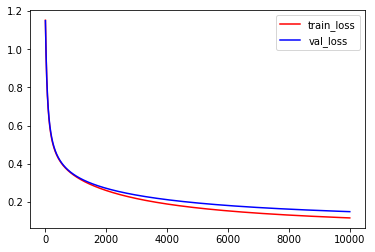

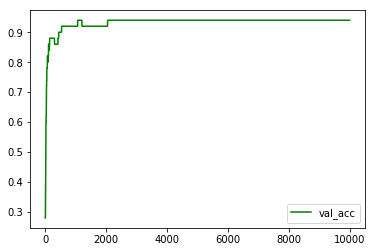

In [49]:
# plot learning curve
plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='val_loss')
plt.legend()

plt.figure()
plt.plot(range(num_epochs), val_acc_list, 'g-', label='val_acc')
plt.legend()

## MNIST

- MNISTはPyTorchの標準機能でデータセットをダウンロードできる
- バッチ単位で読み込めるDataLoaderも簡単に使える

In [50]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [69]:
# Hyper Parameters 
input_size = 784
num_classes = 10
num_epochs = 20
batch_size = 100
learning_rate = 0.001

# MNIST Dataset (Images and Labels)
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [70]:
print(len(train_dataset))
print(len(test_dataset))

# 1データだけ取得
image, label = iter(train_loader).next()
print(type(image), type(label))
print(image.size(), label.size())

60000
10000
<class 'torch.FloatTensor'> <class 'torch.LongTensor'>
torch.Size([100, 1, 28, 28]) torch.Size([100])


In [71]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out

model = LogisticRegression(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

def train(train_loader):
    model.train()
    running_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        running_loss += loss

        loss.backward()
        optimizer.step()

    train_loss = running_loss / len(train_loader)
    
    return train_loss.data[0]

def valid(test_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        running_loss += loss

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels.data).sum()
        total += labels.size(0)

    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    
    return val_loss.data[0], val_acc

loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
    loss = train(train_loader)
    val_loss, val_acc = valid(test_loader)

    print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f'
          % (epoch, loss, val_loss, val_acc))
    
    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 2.0463 val_loss: 10.8309 val_acc: 0.7022
epoch 1, loss: 1.6279 val_loss: 8.8435 val_acc: 0.7655
epoch 2, loss: 1.3590 val_loss: 7.5478 val_acc: 0.7912
epoch 3, loss: 1.1804 val_loss: 6.6658 val_acc: 0.8090
epoch 4, loss: 1.0559 val_loss: 6.0349 val_acc: 0.8189
epoch 5, loss: 0.9650 val_loss: 5.5636 val_acc: 0.8269
epoch 6, loss: 0.8958 val_loss: 5.1983 val_acc: 0.8331
epoch 7, loss: 0.8414 val_loss: 4.9069 val_acc: 0.8380
epoch 8, loss: 0.7975 val_loss: 4.6683 val_acc: 0.8421
epoch 9, loss: 0.7611 val_loss: 4.4693 val_acc: 0.8456
epoch 10, loss: 0.7306 val_loss: 4.3004 val_acc: 0.8491
epoch 11, loss: 0.7044 val_loss: 4.1550 val_acc: 0.8517
epoch 12, loss: 0.6818 val_loss: 4.0283 val_acc: 0.8540
epoch 13, loss: 0.6620 val_loss: 3.9169 val_acc: 0.8557
epoch 14, loss: 0.6445 val_loss: 3.8179 val_acc: 0.8577
epoch 15, loss: 0.6289 val_loss: 3.7294 val_acc: 0.8592
epoch 16, loss: 0.6149 val_loss: 3.6496 val_acc: 0.8610
epoch 17, loss: 0.6022 val_loss: 3.5772 val_acc: 0.8622
e

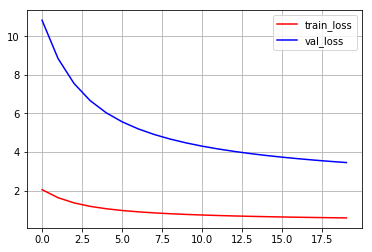

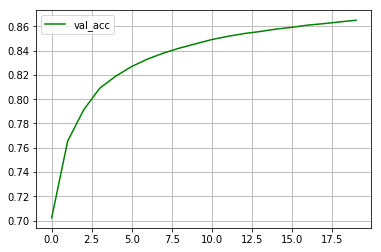

In [72]:
# plot learning curve
plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(range(num_epochs), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.grid()